In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '../datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [5]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_features, train_labels, 
                    epochs=30, batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 12ms/step - loss: 0.5970 - acc: 0.6790 - val_loss: 0.4443 - val_acc: 0.8360
Epoch 2/30
100/100 [==============================] - 1s 11ms/step - loss: 0.4485 - acc: 0.7940 - val_loss: 0.3643 - val_acc: 0.8590
Epoch 3/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3526 - acc: 0.8470 - val_loss: 0.3230 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.3237 - acc: 0.8565 - val_loss: 0.3000 - val_acc: 0.8840
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2939 - acc: 0.8790 - val_loss: 0.2846 - val_acc: 0.8920
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2684 - acc: 0.8905 - val_loss: 0.2791 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.2521 - acc: 0.9015 - val_loss: 0.2677 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 1s 11ms/step - 

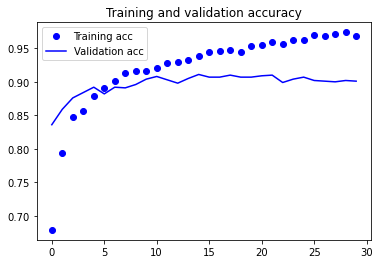

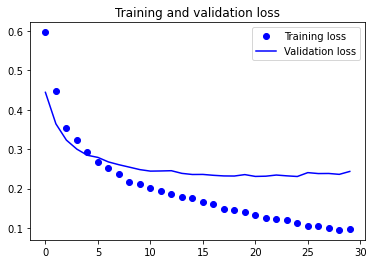

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('before :', len(model.trainable_weights))
conv_base.trainable = False
print('after :', len(model.trainable_weights))

before : 30
after : 4


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(150, 150), 
                                                    batch_size=20, 
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, 
                                                        target_size=(150, 150), 
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30, 
                    validation_data=validation_generator, 
                    validation_steps=50, 
                    verbose=2)

Epoch 1/30
100/100 - 77s - loss: 0.5792 - acc: 0.7045 - val_loss: 0.4188 - val_acc: 0.8430
Epoch 2/30
100/100 - 77s - loss: 0.4678 - acc: 0.7875 - val_loss: 0.3524 - val_acc: 0.8700
Epoch 3/30
100/100 - 77s - loss: 0.4205 - acc: 0.8190 - val_loss: 0.3196 - val_acc: 0.8770
Epoch 4/30
100/100 - 77s - loss: 0.3892 - acc: 0.8325 - val_loss: 0.3036 - val_acc: 0.8800
Epoch 5/30
100/100 - 77s - loss: 0.3956 - acc: 0.8285 - val_loss: 0.2862 - val_acc: 0.8880
Epoch 6/30
100/100 - 77s - loss: 0.3714 - acc: 0.8365 - val_loss: 0.2744 - val_acc: 0.8940
Epoch 7/30
100/100 - 77s - loss: 0.3548 - acc: 0.8405 - val_loss: 0.2720 - val_acc: 0.8880
Epoch 8/30
100/100 - 77s - loss: 0.3401 - acc: 0.8600 - val_loss: 0.2623 - val_acc: 0.8960
Epoch 9/30
100/100 - 77s - loss: 0.3461 - acc: 0.8440 - val_loss: 0.2582 - val_acc: 0.9000
Epoch 10/30
100/100 - 77s - loss: 0.3456 - acc: 0.8485 - val_loss: 0.2625 - val_acc: 0.8930
Epoch 11/30
100/100 - 77s - loss: 0.3391 - acc: 0.8525 - val_loss: 0.2541 - val_acc: 0.90

In [12]:
model.save('cats_and_dogs_small_3.h5')

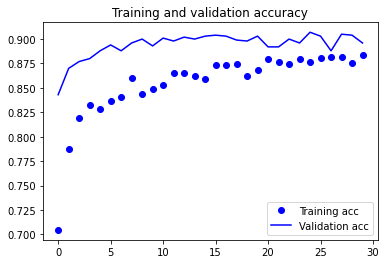

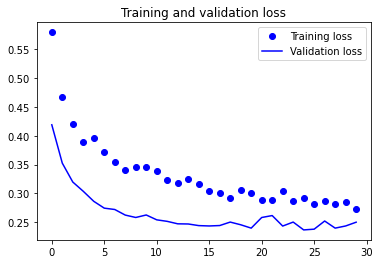

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()